# Datasets & Dataloaders
用于处理数据样本的代码可能会变得混乱、难以维护；理想情况下，我们希望我们的数据集代码和模型训练代码能够解耦，以提高可读性和模块化性。Pytorch提供了torch.utils.data.Dataset和torch.utils.data.Dataloader，允许我们使用预加载的数据集和自己的数据。Dataset存储样本及其相应的标签，Dataloader将Dataset包装为一个可迭代的对象，方便访问样本。

Pytorch提供一些预加载的数据集，如FashionMNIST，这些数据集是torch.utils.data.Dataset的子类，并实现特定于给定数据的函数。
## 1. 加载数据集
以下是如何从torchvision加载FashionMNIST数据集的示例，该数据集包括60000个训练样本和10000个测试样本，每个示例包括一个28x28的灰度图像以及表示0~9中某个数字的标签。我们加载FashionMNIST数据集时具有以下参数：
- root是存储训练/测试数据集的路径
- train指定训练或测试数据集
- download=True，如果root无法从互联网上获取数据，请手动下载
- transform和target_transform指定功能和标签转换

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

26422272it [00:15, 1733596.23it/s]                              


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


29696it [00:00, 82131.55it/s]                           


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


4422656it [00:02, 1498883.77it/s]                             


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


6144it [00:00, 10759834.56it/s]         

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!



/Users/dlq/miniforge3/envs/pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-1w2ckjjv/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2. 迭代和可视化数据集
我们可以像列表一样手动索引Datesets:training_data[index]。我们使用matplotlib可视化训练数据中的一些样本。

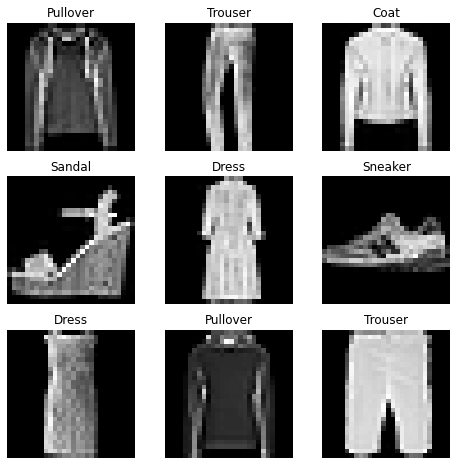

In [5]:
labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## 3. 创建自定义数据集
自定义数据集必须实现三个函数：\_\_init\_\_、\_\_len\_\_和\_\_getitem\_\_。我们想要实现，将FashionMNIST图像存储在目录img_dir中，其标签单独存储在csv文件annotations_file中。

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

- \_\_init\_\_
实例化数据集对象时，\_\_init\_\_函数运行一次，我们初始化包含图像、注释文件和两种变换操作的目录，label.csv文件如下所示：

    tshirt1.jpg, 0

    tshirt2.jpg, 0

    ......

    ankleboot999.jpg, 9

- \_\_len\_\_

    \_\_len\_\_函数返回我们数据集中的样本数量
- \_\_getitem\_\_

    \_\_getitem\_\_函数从给定索引idx的数据集加载并返回样本，根据索引，它能够识别图像在磁盘上的位置，使用read_image将其转换为张量，从self.img_labels中的csv数据中检索相应的标签，调用相应的转换函数，并将张量图像和对应标签以元组的形式返回。

## 4. 准备数据以进行DataLoaders的训练
Dataset一次只接收一个样本的图像和标签，当训练模型的时候，我们往往想要以minibatch的方式传入样本数据，Dataloader是一个可迭代对象，它在一个简单的API中为我们抽象了这种复杂性。

In [12]:
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### 通过Dataloader来进行迭代
我们已经将数据集加载进Dataloader中，然后就可以进行迭代。每一轮迭代都会返回一批train_features和train_labels（批数量由batch_size决定）

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


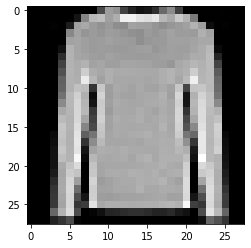

Label: 2


In [13]:
# 展示图片和标签
train_features, train_labels = next(iter(training_dataloader))
print('Feature batch shape:', train_features.size())
print('Labels batch shape:', train_labels.size())
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print('Label:', label.item())